#  <center> Taller  de Aprendizaje Automático </center>
##  <center> Taller 5: Estimación de la demanda de bicicletas compartidas utilizando *Neural Networks*.  </center>

# Introducción

En esta actividad se retomará el problema de la competencia [*Bike Sharing Demand*](https://www.kaggle.com/c/bike-sharing-demand) visto en el Taller 3.
Esta vez las estimaciónes deben obtenerse utilizando la herramienta: *Multilayer Perceptron* (MLP). Es importante mantener la función *Root Mean Squared Logarithmic Error* (RMSLE) como medida de desempeño de manera de poder comparar los resultados con los obtenidos en el Taller 3.

Tanto las preguntas teóricas como la parte práctica de esta actividad están ligadas al contenido del capítulo 10 (*Introduction to
Artificial Neural Networks with
Keras*) del libro del curso.


## Objetivos


*   Trabajar con modelos MLP utilizando la librería [*Keras*](https://keras.io/api/).
*   Probar algunas de las herramientas disponibles para la busqueda de hiperparámetros.

## Formas de trabajo

#### Opción 1: Trabajar localmente

##### Descarga de datos disponibles en Kaggle

Luego, para descargar el dataset de Demanda de Bicicletas:

In [5]:
!kaggle competitions download -c bike-sharing-demand

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\uriel\miniconda3\envs\TAA-py311\Scripts\kaggle.exe\__main__.py", line 4, in <module>
  File "C:\Users\uriel\miniconda3\envs\TAA-py311\Lib\site-packages\kaggle\__init__.py", line 6, in <module>
    api.authenticate()
  File "C:\Users\uriel\miniconda3\envs\TAA-py311\Lib\site-packages\kaggle\api\kaggle_api_extended.py", line 433, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in C:\Users\uriel\.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


Descomprima el archivo descargado:

In [1]:
import shutil
shutil.unpack_archive('./bike-sharing-demand.zip', './')

#### Opción 2:  Trabajar en *Colab*. 

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/TAA-fing/TAA-2025/blob/main/talleres/taller5_demanda_de_bicicletas_con_NNs.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Ejecutar en Google Colab</a>
  </td>
</table>

Se puede trabajar en Google Colab. Para ello es necesario contar con una cuenta de **google drive** y ejecutar un notebook almacenado en dicha cuenta. De lo contrario, no se conservarán los cambios realizados en la sesión. En caso de ya contar con una cuenta, se puede abrir el notebook y luego ir a `Archivo-->Guardar una copia en drive`. 

La siguiente celda monta el disco personal del drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

A continuación, vaya a su cuenta de [Kaggle](https://www.kaggle.com/) (o cree una si aún no lo ha hecho), haga clic en el icono de perfil en la esquina superior derecha de la pantalla y seleccione "Your Account" en la lista desplegable. Luego, seleccione la viñeta "Account" y haga clic en "Create new API token". Entonces un archivo llamado kaggle.json se descargará automáticamente a su carpeta de descargas. Este archivo contiene sus credenciales de inicio de sesión para permitirle acceder a la API.

La siguiente celda realiza la configuración necesaria para obtener datos desde la plataforma Kaggle. Le solicitará que suba el archivo kaggle.json descargado anteriormente.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import files

# El siguiente archivo solicitado es para habilitar la API de Kaggle en el entorno que está trabajando.
# Este archivo se descarga entrando a su perfíl de Kaggle, en la sección API, presionando donde dice: Create New API Token

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

#Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Una vez guardado el *token* se pueden descargar los datos, en este caso se bajarán los datos del dataset de Demanda de Bicicletas:

In [ ]:
!kaggle competitions download -c bike-sharing-demand

In [ ]:
!unzip bike-sharing-demand.zip

## Paquetes a utilizar

En esta actividad se utilizarán algunas bibliotecas auxiliares que deberán ser instaladas. Ejecutar la siguiente celda hasta que se ejecute sin errores. En caso de error, se puede instalar el paquete faltante desde el notebook con el comando:

`!pip install paquete_faltante`

In [123]:
#import comet_ml in the top of your file
from comet_ml import Experiment
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_submission = pd.read_csv('sampleSubmission.csv')

## Parte 1 - Procesamiento de los datos

Dado que ya se ha familiarizado con los datos, se implementa el mismo preprocesamiento que utilizó en el Taller 3.

In [3]:
!pip install keras --upgrade

   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 1.3/1.3 MB 13.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
   ---------------------------------------- 3.0/3.0 MB 15.7 MB/s eta 0:00:00


In [4]:
pip install keras-tuner --upgrade

Note: you may need to restart the kernel to use updated packages.


In [124]:
df_train['datetime'] = pd.to_datetime(df_train['datetime'])

df_train['hour'] = df_train['datetime'].dt.hour
df_train['weekday'] = df_train['datetime'].dt.weekday
df_train['month'] = df_train['datetime'].dt.month 
df_train['year'] = df_train['datetime'].dt.year

y_train_full = df_train['count']
df_train = df_train.drop(['datetime', 'casual', 'registered', 'count'], axis=1) # hay que eliminarlas ya que tiene relación directa con la columna objetivo y no aparecen en el conjunto de *test*.

- Dado que se trabajará con redes neuronales, ¿Cree conveniente realizar alguna modificación en el preprocesamiento?

In [ ]:
Si

## Parte 2 - Multilayer Perceptron (MLP)

Siguiendo el ejemplo de la sección *Building a Regression MLP Using the Sequential API*:


*   Implementar un estimador manteniendo los hiperparámetros del ejemplo.
*   ¿Cuál es la cantidad total de parámetros entrenables de la red?
*   Seleccionar aleatoriamente un *10%* de los datos para validación, y graficar la función de *loss* (*Mean Squared Logarithmic Error*) de entrenamiento y validación.

*Nota: Observe que en el ejemplo se agrega una capa de normalización*

In [8]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df_train)

scaler_y = StandardScaler()
y_train_full_scaled = scaler_y.fit_transform(y_train_full.to_numpy().reshape(-1, 1))


X_train_full, X_test, y_train_full2, y_test = train_test_split(
    X_train_scaled, y_train_full_scaled, train_size=0.9
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full2, train_size=0.9
)

In [9]:


tf.random.set_seed(42)
#norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])

model = tf.keras.Sequential([
#norm_layer,
tf.keras.layers.Dense(50, activation="relu"),
tf.keras.layers.Dense(50, activation="relu"),
tf.keras.layers.Dense(50, activation="relu"),
tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="msle", optimizer=optimizer, metrics=["msle"])
#norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test, rmse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)



Epoch 1/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1211 - msle: 0.1211 - val_loss: 0.0854 - val_msle: 0.0854
Epoch 2/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0823 - msle: 0.0823 - val_loss: 0.0634 - val_msle: 0.0634
Epoch 3/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0664 - msle: 0.0664 - val_loss: 0.0554 - val_msle: 0.0554
Epoch 4/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0574 - msle: 0.0574 - val_loss: 0.0486 - val_msle: 0.0486
Epoch 5/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0495 - msle: 0.0495 - val_loss: 0.0418 - val_msle: 0.0418
Epoch 6/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0420 - msle: 0.0420 - val_loss: 0.0364 - val_msle: 0.0364
Epoch 7/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0339 - msle: 0.0339 - val_loss: 0.0295 - val_msle: 0.0295
Epoch 8/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0273 - msle: 0.0273 - val_loss: 0.0264 - val_msle: 0.0264
Epoch 9/20
276/276 ━━━━━━━━━━━━━━━━━━━━ 

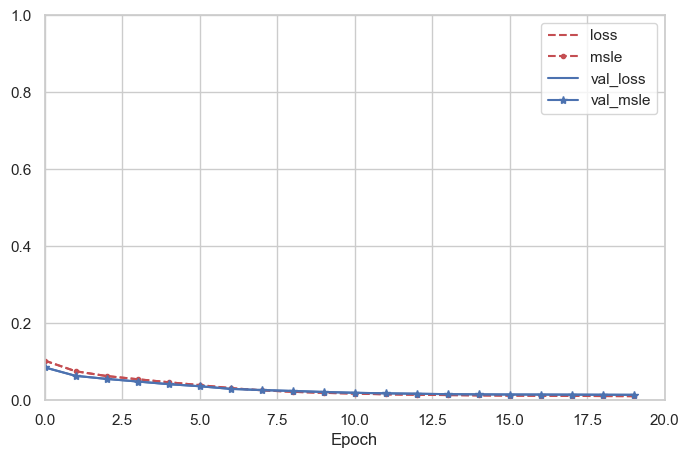

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
pd.DataFrame(history.history).plot(
figsize=(8, 5), xlim=[0, 20], ylim=[0, 1], grid=True, xlabel="Epoch",
style=["r--", "r--.", "b-", "b-*"])
plt.show()


In [11]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │             650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,405 (67.99 KB)

 Trainable params: 5,801 (22.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,604 (45.33 KB)

None


In [12]:
print(y_train)

[[-0.95273167]
 [-0.60492697]
 [ 2.5805225 ]
 ...
 [-0.37305716]
 [-1.04106303]
 [ 1.42117347]]


In [13]:
print(f"Min label: {y_train.min()}, Max label: {y_train.max()}")


Min label: -1.0521044484722468, Max label: 4.3361081667641255


## Parte 3 - Ajuste fino

Siguiendo el ejemplo de la sección *Fine-Tuning Neural Network Hyperparameters*:


*   Utilizar la herramienta *RandomSearch* de *KerasTuner* para la busqueda de hiperparámetros del modelo implementado en *keras*. 
*   Probar el *tip* que se sugiere en la sección *Number of Neurons per Hidden Layer* y comentar los resultados.

In [14]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    options = {"input_shape": input_shape}
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu", **options))
        options = {}
    model.add(keras.layers.Dense(1, **options))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model


In [15]:
keras_reg = KerasRegressor(build_model)

In [17]:
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=2, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
    sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(layers.Dense(1, activation= "relu"))
    model.compile(loss="msle", optimizer=optimizer, metrics=["msle"])
    return model

In [18]:
print("min y_train:", y_train.min())
print("min y_valid:", y_valid.min())

min y_train: -1.0521044484722468
min y_valid: -1.0521044484722468


In [20]:
import keras_tuner as kt
random_search_tuner = kt.RandomSearch(
    build_model,
    objective="val_msle",  
    max_trials=10,
    overwrite=False,
    directory="bike_regression_tuning",
    project_name="random_search",
    seed=42
)
random_search_tuner.search(X_train, y_train, epochs=10,
validation_data=(X_valid, y_valid))


Trial 10 Complete [00h 00m 13s]
val_msle: 0.02732277847826481

Best val_msle So Far: 0.015859199687838554
Total elapsed time: 00h 05m 55s


In [21]:
# Obtener el mejor modelo y los mejores hiperparámetros
best_model = random_search_tuner.get_best_models(num_models=1)[0]
best_hparams = random_search_tuner.get_best_hyperparameters(num_trials=1)[0]

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(best_hparams.values)





Mejores hiperparámetros encontrados:
{'n_hidden': 8, 'n_neurons': 124, 'learning_rate': 0.0005509513888645584, 'optimizer': 'adam'}


C:\Users\ureca\miniconda3\envs\TAA-py311\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


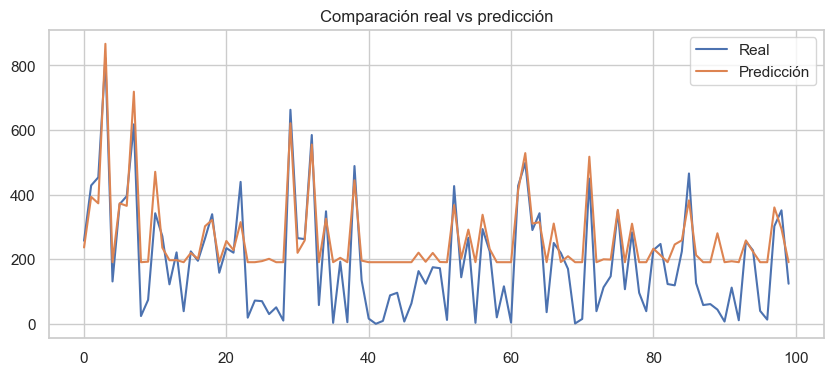

In [22]:
# Predicciones
y_pred_scaled = best_model.predict(X_test)

# Desescalar
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_real = scaler_y.inverse_transform(y_test)

# Comparar primeros valores
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(y_test_real[:100], label="Real")
plt.plot(y_pred[:100], label="Predicción")
plt.legend()
plt.title("Comparación real vs predicción")
plt.show()


## Parte 4 - Ajuste fino (Optuna)

*   Utilizar *Optuna* para la busqueda de hiperparámetros del modelo en *Keras*. Se le sugiere seguir uno de los siguientes ejemplos: [*keras_simple*](https://github.com/optuna/optuna-examples/blob/main/keras/keras_simple.py),  [OptunaSearchCV](https://github.com/optuna/optuna-examples/blob/main/sklearn/sklearn_optuna_search_cv_simple.py).

*Nota: Optuna puede utilizarse para optimizar otras técnicas por fuera de las redes neuronales.*

*Nota2: Keras Tuner permite realizar Optimización bayesiana.*

In [27]:
import optuna
from keras.models import Sequential
from keras.layers import Dense, Input, Flatten
from keras.optimizers import Adam, SGD
from keras.backend import clear_session

EPOCHS = 20
BATCHSIZE = 32

def objective(trial):
    clear_session()

    
    n_hidden = trial.suggest_int("n_hidden", 1, 5)
    n_neurons = trial.suggest_int("n_neurons", 32, 256)
    activation = trial.suggest_categorical("activation", ["relu", "tanh"])
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "sgd"])
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

    if optimizer_name == "adam":
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)

    # Construcción del modelo
    model = Sequential()
    model.add(Input(shape=X_train.shape[1:]))
    for _ in range(n_hidden):
        model.add(Dense(n_neurons, activation=activation))
    model.add(Dense(1))  # Salida para regresión

    model.compile(loss="msle", optimizer=optimizer, metrics=["msle"])

    model.fit(
        X_train,
        y_train,
        validation_data=(X_valid, y_valid),
        shuffle=True,
        batch_size=BATCHSIZE,
        epochs=EPOCHS,
        verbose=0,
    )

    # Evaluamos en validación
    loss, msle = model.evaluate(X_valid, y_valid, verbose=0)
    return msle  # minimizar MAE

# Ejecución del estudio
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30, timeout=600)  # podés ajustar esto

# Resultados
print("Número de trials:", len(study.trials))
print("Mejor trial:")
print("  MAE:", study.best_trial.value)
print("  Hiperparámetros:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")


[I 2025-04-21 15:58:48,430] A new study created in memory with name: no-name-b1c5b030-4983-4df2-afc4-7a6782d3b478
[I 2025-04-21 15:59:02,456] Trial 0 finished with value: 0.09950663149356842 and parameters: {'n_hidden': 1, 'n_neurons': 235, 'activation': 'tanh', 'optimizer': 'sgd', 'learning_rate': 0.00016979462356411519}. Best is trial 0 with value: 0.09950663149356842.
[I 2025-04-21 15:59:16,261] Trial 1 finished with value: 0.02885792963206768 and parameters: {'n_hidden': 1, 'n_neurons': 252, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0008034551934351517}. Best is trial 1 with value: 0.02885792963206768.
[I 2025-04-21 15:59:29,999] Trial 2 finished with value: 0.09081289917230606 and parameters: {'n_hidden': 4, 'n_neurons': 45, 'activation': 'tanh', 'optimizer': 'sgd', 'learning_rate': 0.003950979165471675}. Best is trial 1 with value: 0.02885792963206768.
[I 2025-04-21 15:59:53,826] Trial 3 finished with value: 0.015481044538319111 and parameters: {'n_hidden': 5,

Número de trials: 30
Mejor trial:
  MAE: 0.011440730653703213
  Hiperparámetros:
    n_hidden: 5
    n_neurons: 207
    activation: relu
    optimizer: adam
    learning_rate: 0.0005675377088122445


## Parte 5 - Pipeline



*   Incorporar el estimador con mejor desempeño a un *pipeline* similar al implementado en el Taller 3. Puede ser útil la biblioteca [scikeras](https://adriangb.com/scikeras/stable/migration.html).
*   Subir los resultados de los datos *test* a la página de la competencia.



In [198]:
from scikeras.wrappers import KerasRegressor
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_squared_log_error, make_scorer

from sklearn.metrics import make_scorer, mean_squared_log_error
import numpy as np


rmsle_scorer = make_scorer(lambda y_true, y_pred: -np.sqrt(mean_squared_log_error(y_true, y_pred)))



best_params = study.best_trial.params

n_hidden = best_params["n_hidden"]
n_neurons = best_params["n_neurons"]
learning_rate = best_params["learning_rate"]
optimizer_name = best_params["optimizer"]
activation_name = best_params["activation"]

print(best_params)

{'n_hidden': 5, 'n_neurons': 207, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0005675377088122445}


In [199]:
from scikeras.wrappers import KerasRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [258]:

df_train_sin = df_train.drop(columns=['temp','workingday'])
print(df_train_sin.columns.tolist())

['season', 'holiday', 'weather', 'atemp', 'humidity', 'windspeed', 'hour', 'weekday', 'month', 'year']


In [259]:
from scikeras.wrappers import KerasRegressor

from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD  
from tensorflow.keras import Input



def create_model(n_hidden=5, n_neurons=207, learning_rate=0.0005675377088122445, optimizer_name="adam", activation_name="relu", input_shape=10):
    model = Sequential()
    
    model.add(Input(shape=(input_shape,)))
    model.add(Dense(n_neurons, activation=activation_name))
    
    for _ in range(n_hidden - 1):
        model.add(Dense(n_neurons, activation=activation_name))
        
    model.add(Dense(1,activation="relu")) 
    
    if optimizer_name == "adam":
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == "sgd":
        optimizer = SGD(learning_rate=learning_rate)
    else:
        raise ValueError(f"Optimizer {optimizer_name} no reconocido")
    
    model.compile(loss="msle", optimizer=optimizer)
    return model



In [260]:
regressor = KerasRegressor(
    model=create_model,
    epochs=30,
    batch_size=16
)

In [265]:
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df_train_sin)

scaler_y = StandardScaler()
y_train_full_scaled = scaler_y.fit_transform(y_train_full.to_numpy().reshape(-1, 1))


X_train_full, X_test, y_train_full2, y_test = train_test_split(
    X_train_scaled, y_train_full_scaled, train_size=0.9
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full2, train_size=0.9
)

In [262]:
from sklearn.metrics import mean_squared_log_error

regressor.fit(X_train, y_train, validation_data=(X_valid, y_valid))
y_pred_test = regressor.predict(X_test)


y_pred_test_rescaled = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1))
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1))

rmsle = np.sqrt(mean_squared_log_error(y_test_rescaled, y_pred_test_rescaled))

print(f"RMSLE: {rmsle}")

Epoch 1/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1024 - val_loss: 0.0579
Epoch 2/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0594 - val_loss: 0.0461
Epoch 3/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0380 - val_loss: 0.0380
Epoch 4/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0256 - val_loss: 0.0171
Epoch 5/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0193 - val_loss: 0.0212
Epoch 6/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0175 - val_loss: 0.0173
Epoch 7/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0152 - val_loss: 0.0159
Epoch 8/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0135 - val_loss: 0.0149
Epoch 9/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0129 - val_loss: 0.0323
Epoch 10/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0147 - val_loss: 0.0143
Epoch 11/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0113 - val_loss: 0.0142
Epoch 12/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

In [263]:
n_hidden = best_params["n_hidden"]
n_neurons = best_params["n_neurons"]
learning_rate = best_params["learning_rate"]
optimizer_name = best_params["optimizer"]
activation_name = best_params["activation"]


def create_model(input_shape=12):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    model.add(Dense(n_neurons, activation=activation_name))
    
    for _ in range(n_hidden - 1):
        model.add(Dense(n_neurons, activation=activation_name))
        
    model.add(Dense(1, activation="relu")) 
    
    # Elegir optimizador
    if optimizer_name == "adam":
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == "sgd":
        optimizer = SGD(learning_rate=learning_rate)
    else:
        raise ValueError(f"Optimizer {optimizer_name} no reconocido")

    model.compile(loss="msle", optimizer=optimizer)
    return model



scaler = StandardScaler()
X_train_scaled2 = scaler.fit_transform(df_train)

scaler_y = StandardScaler()
y_train_full_scaled2 = scaler_y.fit_transform(y_train_full.to_numpy().reshape(-1, 1))


X_train_full2, X_test2, y_train_full3, y_test2 = train_test_split(
    X_train_scaled2, y_train_full_scaled2, train_size=0.9
)
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(
    X_train_full2, y_train_full3, train_size=0.9
)

modelo_NN  = create_model()
regressor = KerasRegressor(model=modelo_NN , epochs=30, batch_size=16)

regressor.fit(X_train2, y_train2, validation_data=(X_valid2, y_valid2))
y_pred_test2 = regressor.predict(X_test2)


y_pred_test_rescaled2 = scaler_y.inverse_transform(y_pred_test2.reshape(-1, 1))
y_test_rescaled2 = scaler_y.inverse_transform(y_test2.reshape(-1, 1))

rmsle2 = np.sqrt(mean_squared_log_error(y_test_rescaled2, y_pred_test_rescaled2))

print(f"RMSLE: {rmsle2}")

Epoch 1/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0996 - val_loss: 0.0674
Epoch 2/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0555 - val_loss: 0.0383
Epoch 3/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0372 - val_loss: 0.0329
Epoch 4/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0265 - val_loss: 0.0284
Epoch 5/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0216 - val_loss: 0.0275
Epoch 6/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0186 - val_loss: 0.0219
Epoch 7/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0168 - val_loss: 0.0213
Epoch 8/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0160 - val_loss: 0.0230
Epoch 9/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0142 - val_loss: 0.0243
Epoch 10/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0140 - val_loss: 0.0244
Epoch 11/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0131 - val_loss: 0.0218
Epoch 12/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

In [264]:
modelo_NN.summary()

Model: "sequential_94"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_526 (Dense)                    │ (None, 207)                 │           2,691 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_527 (Dense)                    │ (None, 207)                 │          43,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_528 (Dense)                    │ (None, 207)                 │          43,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_529 (Dense)                    │ (None, 207)                 │          43,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_530 (Dense)                    │ (None, 207)                 │          43,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_531 (Dense)                    │ (None, 1)                   │             208 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 525,371 (2.00 MB)

 Trainable params: 175,123 (684.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 350,248 (1.34 MB)

[I 2025-04-23 22:33:55,787] A new study created in memory with name: no-name-7f826012-d2d9-47f6-97ab-19278fe50cc3
[I 2025-04-23 22:34:20,192] Trial 0 finished with value: 0.040204744786024094 and parameters: {'n_hidden': 3, 'n_neurons': 156, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.00699831474307077}. Best is trial 0 with value: 0.040204744786024094.
[I 2025-04-23 22:34:38,556] Trial 1 finished with value: 0.015043715015053749 and parameters: {'n_hidden': 4, 'n_neurons': 68, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.0018638194349442701}. Best is trial 1 with value: 0.015043715015053749.
[I 2025-04-23 22:34:56,603] Trial 2 finished with value: 0.13764896988868713 and parameters: {'n_hidden': 5, 'n_neurons': 68, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.00019101968469259557}. Best is trial 1 with value: 0.015043715015053749.
[I 2025-04-23 22:35:12,441] Trial 3 finished with value: 0.12754200398921967 and parameters: {'n_hidden':

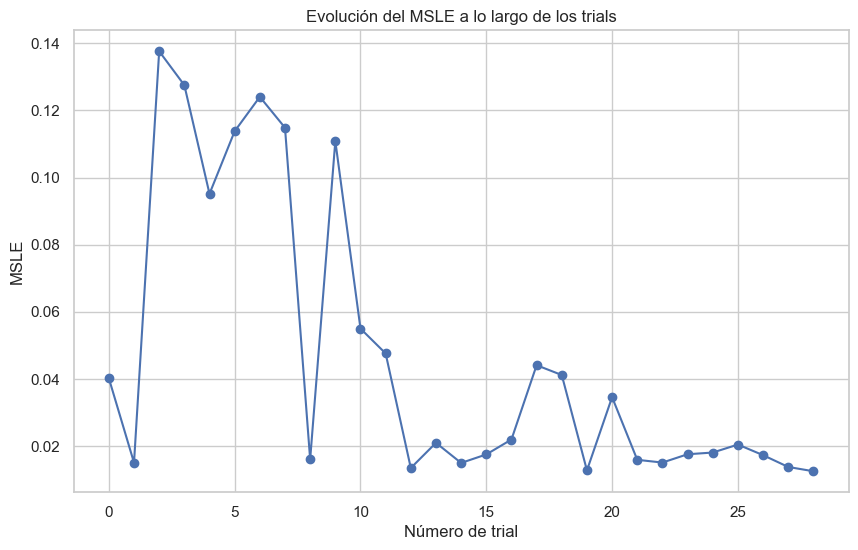

Top 5 trials:
Trial 0:
  MSLE: 0.040204744786024094
  Hiperparámetros: {'n_hidden': 3, 'n_neurons': 156, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.00699831474307077}
------------------------------
Trial 1:
  MSLE: 0.015043715015053749
  Hiperparámetros: {'n_hidden': 4, 'n_neurons': 68, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.0018638194349442701}
------------------------------
Trial 2:
  MSLE: 0.13764896988868713
  Hiperparámetros: {'n_hidden': 5, 'n_neurons': 68, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.00019101968469259557}
------------------------------
Trial 3:
  MSLE: 0.12754200398921967
  Hiperparámetros: {'n_hidden': 3, 'n_neurons': 85, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.0001611442095281639}
------------------------------
Trial 4:
  MSLE: 0.0951659232378006
  Hiperparámetros: {'n_hidden': 4, 'n_neurons': 60, 'activation': 'relu', 'optimizer': 'sgd', 'learning_rate': 0.004362470145176284}
-----

In [266]:
import optuna
from keras.models import Sequential
from keras.layers import Dense, Input, Flatten
from keras.optimizers import Adam, SGD
from keras.backend import clear_session

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df_train_sin)

scaler_y = StandardScaler()
y_train_full_scaled = scaler_y.fit_transform(y_train_full.to_numpy().reshape(-1, 1))


X_train_full, X_test, y_train_full2, y_test = train_test_split(
    X_train_scaled, y_train_full_scaled, train_size=0.9
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full2, train_size=0.9
)

EPOCHS = 20
BATCHSIZE = 32

def objective(trial):
    clear_session()

    
    n_hidden = trial.suggest_int("n_hidden", 1, 5)
    n_neurons = trial.suggest_int("n_neurons", 32, 256)
    activation = trial.suggest_categorical("activation", ["relu", "tanh"])
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "sgd"])
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)

    if optimizer_name == "adam":
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)

    # Construcción del modelo
    model = Sequential()
    model.add(Input(shape=X_train.shape[1:]))
    for _ in range(n_hidden):
        model.add(Dense(n_neurons, activation=activation))
    model.add(Dense(1))  # Salida para regresión

    model.compile(loss="msle", optimizer=optimizer, metrics=["msle"])

    model.fit(
        X_train,
        y_train,
        validation_data=(X_valid, y_valid),
        shuffle=True,
        batch_size=BATCHSIZE,
        epochs=EPOCHS,
        verbose=0,
    )

    # Evaluamos en validación
    loss, msle = model.evaluate(X_valid, y_valid, verbose=0)
    return msle  

# Ejecución del estudio
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=90, timeout=600)  # podés ajustar esto

# Resultados
msle_values = [trial.value for trial in study.trials]

# Crear un gráfico
plt.figure(figsize=(10, 6))
plt.plot(msle_values, marker="o")
plt.title("Evolución del MSLE a lo largo de los trials")
plt.xlabel("Número de trial")
plt.ylabel("MSLE")
plt.show()

# Mostrar las 5 mejores pruebas
print("Top 5 trials:")
for trial in study.trials[:5]:
    print(f"Trial {trial.number}:")
    print(f"  MSLE: {trial.value}")
    print(f"  Hiperparámetros: {trial.params}")
    print("-" * 30)


In [267]:
print("Número de trials:", len(study.trials))
print("Mejor trial:")
print("  MAE:", study.best_trial.value)
print("  Hiperparámetros:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

Número de trials: 29
Mejor trial:
  MAE: 0.012495175935328007
  Hiperparámetros:
    n_hidden: 3
    n_neurons: 145
    activation: tanh
    optimizer: adam
    learning_rate: 0.0010380761191225833


In [269]:
n_hidden = 3
n_neurons = 145
learning_rate = 0.0010380761191225833
optimizer_name = 'adam'
activation_name = 'tanh'


def create_model(input_shape=12):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    model.add(Dense(n_neurons, activation=activation_name))
    
    for _ in range(n_hidden - 1):
        model.add(Dense(n_neurons, activation=activation_name))
        
    model.add(Dense(1, activation="relu")) 
    
    # Elegir optimizador
    if optimizer_name == "adam":
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == "sgd":
        optimizer = SGD(learning_rate=learning_rate)
    else:
        raise ValueError(f"Optimizer {optimizer_name} no reconocido")

    model.compile(loss="msle", optimizer=optimizer)
    return model



scaler = StandardScaler()
X_train_scaled2 = scaler.fit_transform(df_train)

scaler_y = StandardScaler()
y_train_full_scaled2 = scaler_y.fit_transform(y_train_full.to_numpy().reshape(-1, 1))


X_train_full2, X_test2, y_train_full3, y_test2 = train_test_split(
    X_train_scaled2, y_train_full_scaled2, train_size=0.9
)
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(
    X_train_full2, y_train_full3, train_size=0.9
)

modelo_NN  = create_model()
regressor = KerasRegressor(model=modelo_NN , epochs=30, batch_size=16)

regressor.fit(X_train2, y_train2, validation_data=(X_valid2, y_valid2))
y_pred_test2 = regressor.predict(X_test2)


y_pred_test_rescaled2 = scaler_y.inverse_transform(y_pred_test2.reshape(-1, 1))
y_test_rescaled2 = scaler_y.inverse_transform(y_test2.reshape(-1, 1))

rmsle2 = np.sqrt(mean_squared_log_error(y_test_rescaled2, y_pred_test_rescaled2))

print(f"RMSLE: {rmsle2}")

Epoch 1/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1284 - val_loss: 0.0838
Epoch 2/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0736 - val_loss: 0.0685
Epoch 3/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0530 - val_loss: 0.0612
Epoch 4/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0443 - val_loss: 0.0409
Epoch 5/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0326 - val_loss: 0.0263
Epoch 6/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0241 - val_loss: 0.0259
Epoch 7/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0217 - val_loss: 0.0211
Epoch 8/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0192 - val_loss: 0.0199
Epoch 9/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0189 - val_loss: 0.0198
Epoch 10/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0176 - val_loss: 0.0190
Epoch 11/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0165 - val_loss: 0.0201
Epoch 12/30
552/552 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step